# Predicting Box Office Revenue

## Preprocessing and Training Notebook

The purpose of this notebook is twofold:

First I want to reduce the dimensionality of my data set in order to make the machine learning models I have to work with more tenable. Currently I have over 10,000 features and only 2,333 observations in the data set, causing serious computational slowdown for my models.  Further, at the time when this notebook was initially written the machine I'm working on didn't have the computational power to even create dummy variables from my 'cast' and 'crew' categories.  


I plan to 'bin' categorical dummy variables into new features to reduce dimensionality.  This is relatively easy for features that are highly skewed (spoken language) or where each variable has a low frequency in the data set compared to 'None' (collection).  However I'll need to test performance on a basic linear/polynomial regressor for other categories where the data is exponentially skewed and there isn't a clear way to bin the data.  This will allow me to compare R^2 and Mean Absolute Percent Error metrics and determine which method for dimensionality reduction allows for the more accurate model. 

Finally, I'll use Lasso and Ridge regressors to test my initial linear regressor for overfit; additionally I'll be able to use the Lasso regressor coefficients to determine what features can be dropped to further reduce dimensionality and complexity. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
import time
import sklearn

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# Read in CSV from EDA notebook

boxoffice = pd.read_csv('../Data/boxoffice_EDA.csv', index_col=0, header=[0,1])
boxoffice.shape

(2333, 10456)

In [3]:
boxoffice.head(3)

Genre                                                                    \
  Action Adventure Animation Comedy Crime Documentary Drama Family Fantasy   
0      0         0         0      1     0           0     1      1       0   
1      0         0         0      0     0           0     1      0       0   
2      0         1         1      0     0           0     0      1       0   

           ... Release_month                             
  Foreign  ...             3  4  5  6  7  8  9 10 11 12  
0       0  ...             0  0  0  0  0  1  0  0  0  0  
1       0  ...             0  0  0  0  0  0  0  1  0  0  
2       0  ...             0  0  0  0  0  1  0  0  0  0  

[3 rows x 10456 columns]

In [4]:
# Displaying names of top level of multi-index for later reference
boxoffice.columns.get_level_values(0).unique()

Index(['Genre', 'Collection', 'Company', 'Country', 'Spoken_lang', 'Keywords',
       'Descriptive', 'Numerical', 'Release_year', 'Release_month'],
      dtype='object')

## Binning Categorical Data

To begin I want to significantly cut down on the number of features that I have in the data set.  By far the largest category that I have is Keywords, however the distribution of that category and several others presents several options for binning my data.  I can bin them into quartiles by either frequency or median/mean revenue in the data set. 

However I do have several feature categories that I won't be touching: Genre, Release_year, Country, and Release_month.  These categories all have fewer than 70 individual features.  Additionally I have a compelling reason to believe that each of these will have a large impact on revenue.  Genre, Release_year, and Release_month all were significantly more evenly distributed across films than other categories.  For these three categories median revenue was also skewed towards certain sub-categories which indicates that they have an impact revenue.  

While the Country category is **heavily** skewed towards films made in the United States, revenue is heavily skewed towards more 'exotic' countries.  This is likely a result of blockbuster films like 'Pirates of the Carribean' or 'The Avengers' being filmed on site in other locations.  I suspect that this category will be highly correlated with budget and may be dropped after I check Lasso regresor coefficients.  Regardless, this category only has 67 sub-categories and consolidating those into fewer bins will lose what appears to be useful information with minimal impact on reducing the 10,456 dimensions that the data set currently has.

This means that I need to bin the Spoken_lang, Company, Keywords, and Collection columns.  Later I'll come back through and treat the Cast and Crew categories the same as the Keyword category once I have access to a machine with enough RAM to handle those categories. 

The best place for me to start with binning is going to be the Spoken_lang category since it's highly skewed towards the 'English' sub-category.

#### Binning Spoken_lang

Based on the work from my EDA notebook the 'English' sub-category accounts for 2,180 films in this data set.  It's clear that the simplest way to bin this category is to reduce it to a single column that indicates if a film's primary language is English or not.

In [5]:
# Create a list of column lables to be dropped
dropped = list(boxoffice['Spoken_lang'].columns)
dropped.remove('English')

In [6]:
# for loop to iterate over the dropped list and remove all languages from Spoken_lang other than english
for col in dropped:
    boxoffice.drop(col, level=1, axis=1, inplace=True)

In [7]:
# verify that English is the only remaining column
boxoffice.Spoken_lang.head(3)

,English
0,1
1,1
2,1


#### Binning Film Collection dummy variables

Ultimately this was going to be relatively complex with the multi-indexed dataframe so I went back to my EDA notebook and created a boolean column that indicates if a film belongs to a collection or not.  The final step is to transform this into the value for 1 or 0. 

In [8]:
# Casting the column in question to a numeric data type
boxoffice['Descriptive', 'Collection'] = boxoffice['Descriptive', 'Collection'].astype('int')
boxoffice['Descriptive', 'Collection'].head(3)

0    1
1    0
2    0
Name: (Descriptive, Collection), dtype: int32

In [9]:
boxoffice['Descriptive'].head(3)

,original_title,overview,tagline,title,Collection
0,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,1
1,Whiplash,"Under the direction of a ruthless instructor, ...",The road to greatness can take you to the edge.,Whiplash,0
2,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",NaN,Pinocchio and the Emperor of the Night,0


While I'm working on this column in Descriptive I'm also going to drop the overview, tagline, and original_title columns, and set the index to the title column

In [10]:
boxoffice.drop('overview', level=1, axis=1, inplace=True)
boxoffice.drop('tagline', level=1, axis=1, inplace=True)
boxoffice.drop('original_title', level=1, axis=1, inplace=True)
# Storing the titles in a seperate Series for later use as needed
Titles = boxoffice['Descriptive', 'title']
boxoffice.drop('title', level=1, axis=1, inplace=True)
boxoffice.drop('Collection', level=0, axis=1, inplace=True)

In [11]:
#Verify that the Descriptive category has been reduced to only the one-hot encoded column for collections
boxoffice['Descriptive'].head(3)

,Collection
0,1
1,0
2,0


## Testing the accuracy of linear regression with the data set as is

At this point I have a huge number of columns, and I haven't made significant reductions in the number of features yet. 

However once I've binned the Company and Keyword columns I'll have eliminated thousands of features.  Prior to doing this I want to get a baseline for how accurate a model is with all of these columns left in the data set. 

The reason that this is important to do now, prior to reducing the dimensionality of the Company and Keywords categories is that each movie has multiple companies and keywords associated with it, while there is only a single language and film collection for each movie.  Reducing the Spoken_lang and Collection categories isn't eliminating complex information about each film like binning the Company and Keywords categories will be, since each film can have multiple companies or keywords, but only a single film collection or spoken language.

Once I have a baseline of performance with the entire dataset using a dummy regressor as well as a general linear regression model with only the numerical data; I'll build up complexity by adding in additional categorical data to assess which provides the best performance. The purpose of building my dataset is to help identify at which point overfitting becomes a problem and decide if, and to what degree, I need to simplify several categories of data.

### Train / Test Split

Here I plan to create a train / test split that I'll work with for the remainder of this notebook, and test the accuracy of my best models/data at the end to assess model performance prior to attempting different regression models in the subsequent notebook. 

In [12]:
# Separating out the target variable
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
# Scaling the numerical data in X 
scaler=StandardScaler()
scaler.fit(X['Numerical'])
X['Numerical'] = scaler.transform(X['Numerical'])
# Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Checking performance of a dummy regressor

In [13]:
mean_reg = DummyRegressor(strategy='mean')
mean_reg.fit(X_train, y_train)
mean_reg.constant_

array([[1.49674973e+08]])

In [14]:
# Evaluating the mean with mean absolute percent error, R-squared, and root mean squared error
pred = mean_reg.predict(X_train)
MAPE_mean = round(mean_absolute_percentage_error(y_train, pred), 5)*100
R2_mean = round(r2_score(y_train, pred), 5)
RMSE_mean = round(mean_squared_error(y_train, pred, squared=False), 5)
print('Mean predictor mape score: ', MAPE_mean)
print('Mean predictor r^2 score: ', R2_mean)
print('Mean predictor rmse score: ', RMSE_mean)

dummy = {'MAPE': MAPE_mean, 'R2':R2_mean, 'RMSE':RMSE_mean}

Mean predictor mape score:  3227.6859999999997
Mean predictor r^2 score:  0.0
Mean predictor rmse score:  179819930.675


In [15]:
np.std(y)

176693296.3539534

*This block of code will be reproduced for each iteration of the linear regression model.  At the end of this notebook I'll be able to evaluate the scoring metrics side by side and take note of any patterns.*

It seems that the mean revenue is not a strong predictor, which is reasonable.  The smallest value in my target variable is around 5,000 USD, and the largest is over 1.5 Billion USD - a significant jump in revenue to the point where the mean value is actually less than 10% of the largest revenue value.  At the same time the mean revenue for this data set is 2,500% of the smallest value.  There is ***significant*** variability in the target metric for this business problem, which means that I'll need to decide ahead of time what a 'good' metric score will mean.  

Given that at it's core, this problem is about predicting human behavior (purchasing of movie tickets), an R-Squared value of 0.5 will be considered 'good'.  This is something that has been cited in multiple blogs online as a good score for predicting human behavior, such as [Jim Frost's blog.](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

Given the huge variability around the mean, and what will be resultingly large mean % error and root-mean-squared errors I think that it's prudent to consider any RMSE score that is less than or equal to one standard deviation as 'good' for now.  Since I'll be saving all of these scores and comparing them at the end of this notebook I'll use that as a standard to make initial judements on as I work to that point.  

Mean absolute percentage error is going to be a strong measure of how accurate the model is given the massive scale I'm working with, I'm not sure what I could even call a 'good' MAPE score.  Having run some initial models in a scratch notebook (appended in GitHub), and seeing how the dummy regressor using the mean performs here I believe that any MAPE score less than 1000% should be considered passable, and that anything less than 500% should be considered good. 

At the end of this notebook I'll be able to identify a subset(s) of my data that will allow a linear regression model to achieve these scores:

***R-squared: 0.5***

***MAPE: 500%***

***RMSE: 176,693,296 USD***

In [16]:
# Creates a dictionary of metrics to be passed to each cross_validate function using the correct syntax for 'cross_validate'
metrics = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error','r2']

## Iterating over versions of the data set with a linear regressor

Moving forward I'll be using forward selection to identify which version of my data set provides the best linear regression performance in order to inform what subset of the data is used in my modeling notebook on other types of regression models.  I'll be saving the scoring metrics for each model and comparing those results to inform my approach in the next notebook. 

I'll forward select different categories in this data set, starting with those that provide the most even distribution of revenue among their members.  In my previous notebook it was clear that revenue is exponentially distributed among the members of each category.  The goal of this process is to identify overfit with the data. As categories get larger the skew of the distribution of revenue becomes more extreme, making forward-selection a good method to use in this instance.

### Linear regression with only numerical data

In [17]:
linear_num = LinearRegression()

In [18]:
#subset the training data on numeric only
Num_train = X_train.Numerical
Num_train.shape

(1866, 5)

In [19]:
# leaving 'cv' as the default 5-folds
num_results = cross_validate(linear_num, Num_train, y_train, scoring=metrics)
#showing results to more easily create a replicatable method of collecting the mean score for each metric
num_results

{'fit_time': array([0.01546741, 0.00836968, 0.00799942, 0.00799918, 0.00799966]),
 'score_time': array([0.0079987, 0.0083313, 0.       , 0.       , 0.       ]),
 'test_neg_mean_absolute_percentage_error': array([ -9.76759806, -25.05493649, -10.77624981,  -4.95096175,
         -7.36415794]),
 'test_neg_mean_squared_error': array([-1.61322403e+16, -1.33388401e+16, -1.92714273e+16, -1.36618831e+16,
        -1.57171279e+16]),
 'test_r2': array([0.48414671, 0.60012038, 0.45986548, 0.58608044, 0.44244005])}

In [20]:
# Use numpy mathematical functions to get the mean score for each metric
MAPE_num = round(np.mean(np.abs(num_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_num = round(np.sqrt(np.mean(np.abs(num_results['test_neg_mean_squared_error']))), 5)
R2_num = round(np.mean(num_results['test_r2']), 5)
print('MAPE_num: ', MAPE_num)
print('RMSE_num: ', RMSE_num)
print('R2_num: ', R2_num)

num = {"MAPE":MAPE_num, "RMSE":RMSE_num, "R2":R2_num}

MAPE_num:  1158.278
RMSE_num:  124997214.85881
R2_num:  0.51453


### Linear regression with Numerical & Genre data

In [21]:
linear_genre = LinearRegression()

In [22]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Spoken_lang', 'Keywords', 'Descriptive', 'Release_year', 'Release_month']
Genre = X_train
for item in drop_list:
    Genre = Genre.drop(item, level=0, axis=1)
Genre.shape

(1866, 25)

In [23]:
genre_results = cross_validate(linear_genre, Genre, y_train, scoring=metrics)
MAPE_genre = round(np.mean(np.abs(genre_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_genre = round(np.sqrt(np.mean(np.abs(genre_results['test_neg_mean_squared_error']))), 5)
R2_genre = round(np.mean(genre_results['test_r2']), 5)
print('MAPE_genre: ', MAPE_genre)
print('RMSE_genre: ', RMSE_genre)
print('R2_genre: ', R2_genre)

genre = {'MAPE':MAPE_genre, "RMSE":RMSE_genre, 'R2':R2_genre}

MAPE_genre:  1457.404
RMSE_genre:  122561605.53471
R2_genre:  0.53345


Adding in the categorical data for genres has increased the % error and total dollar error of the model, while increasing R-squared metrics.  

### Linear regression adding in collection information

In [24]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Spoken_lang', 'Keywords', 'Release_year', 'Release_month']
Collection = X_train
for item in drop_list:
    Collection = Collection.drop(item, level=0, axis=1)
Collection.shape

(1866, 26)

In [25]:
linear_col = LinearRegression()

In [26]:
col_results = cross_validate(linear_col, Collection, y_train, scoring=metrics)
MAPE_col = round(np.mean(np.abs(col_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_col = round(np.sqrt(np.mean(np.abs(col_results['test_neg_mean_squared_error']))), 5)
R2_col = round(np.mean(col_results['test_r2']), 5)
print('MAPE_col: ', MAPE_col)
print('RMSE_col: ', RMSE_col)
print('R2_col: ', R2_col)

collection = {"MAPE":MAPE_col, "RMSE":RMSE_col, "R2":R2_col}

MAPE_col:  1728.879
RMSE_col:  117966542.51019
R2_col:  0.56711


Aggain, adding in the boolean for collection information has decreased the % error and RMSE metrics, while increasing the R-squared score.

### Linear regression adding in language data

In [27]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Keywords', 'Release_year', 'Release_month']
Lang = X_train
for item in drop_list:
    Lang = Lang.drop(item, level=0, axis=1)
Lang.shape

(1866, 27)

In [28]:
linear_lang = LinearRegression()

In [29]:
Lang_results = cross_validate(linear_lang, Lang, y_train, scoring=metrics)
MAPE_lang = round(np.mean(np.abs(Lang_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_lang = round(np.sqrt(np.mean(np.abs(Lang_results['test_neg_mean_squared_error']))), 5)
R2_lang = round(np.mean(Lang_results['test_r2']), 5)
print('MAPE_lang: ', MAPE_lang)
print('RMSE_lang: ', RMSE_lang)
print('R2_lang: ', R2_lang)

language = {"MAPE":MAPE_lang, "RMSE": RMSE_lang, "R2":R2_lang}

MAPE_lang:  1720.9969999999998
RMSE_lang:  117904793.96104
R2_lang:  0.56754


Somewhat surprisingly adding in language information has marginally improved the % error and RMSE scores, **and** improved the R-squared score slightly.  It's notable that all three scores improved here.  In the scratch notebook I was working with prior to this removing categorical information usually improved the MAPE/RMSE **or** R-squared, but not both.   This could be a result of using a different approach (macro-elimination) to test for overfit in that notebook, or perhaps is some interaction between Spoken_lang and the other categories that are present.

### Linear regression after adding in data on the release month for each film

Note: This is not time-series data, but rather one-hot-encoded features for each month indicating the month that a film was released in.

In [30]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Keywords', 'Release_year']
Month = X_train
for item in drop_list:
    Month = Month.drop(item, level=0, axis=1)
Month.shape

(1866, 39)

In [31]:
linear_month = LinearRegression()

In [32]:
month_results = cross_validate(linear_month, Month, y_train, scoring=metrics)
MAPE_month = round(np.mean(np.abs(month_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_month = round(np.sqrt(np.mean(np.abs(month_results['test_neg_mean_squared_error']))), 5)
R2_month = round(np.mean(month_results['test_r2']), 5)
print('MAPE_month: ', MAPE_month)
print('RMSE_month: ', RMSE_month)
print('R2_month: ', R2_month)

month = {"MAPE":MAPE_month, "RMSE":RMSE_month, "R2":R2_month}

MAPE_month:  1690.456
RMSE_month:  118443217.24308
R2_month:  0.56317


Monthly data seems to have improved the MAPE score slightly, however it has equally slightly reduced the RMSE and R-squared scores.  I suspect that this will have a marginal impact on the model performance overall.

### Linear regression including data on a film's release year

In [33]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Keywords']
Year = X_train
for item in drop_list:
    Year = Year.drop(item, level=0, axis=1)
Year.shape

(1866, 87)

In [34]:
linear_year = LinearRegression()

In [35]:
annual_results = cross_validate(linear_year, Year, y_train, scoring=metrics)
MAPE_year = round(np.mean(np.abs(annual_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_year = round(np.sqrt(np.mean(np.abs(annual_results['test_neg_mean_squared_error']))), 5)
R2_year = round(np.mean(annual_results['test_r2']), 5)
print('MAPE_year: ', MAPE_year)
print('RMSE_year: ', RMSE_year)
print('R2_year: ', R2_year)

annual = {'MAPE':MAPE_year, "RMSE":RMSE_year, "R2":R2_year}

MAPE_year:  20503584973233.758
RMSE_year:  8.76132230490481e+18
R2_year:  -2.1514307307889167e+21


### Linear Regression adding in information on a film's production companies

This segment of data is more difficult to bin, since each film has multiple production companies that helped to create it. 

In [36]:
drop_list = ['Country', 'Keywords']
Company = X_train
for item in drop_list:
    Company = Company.drop(item, level=0, axis=1)
Company.shape

(1866, 2775)

In [37]:
linear_co = LinearRegression()

In [38]:
company_results = cross_validate(linear_co, Company, y_train, scoring=metrics)
MAPE_co = round(np.mean(np.abs(company_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_co = round(np.sqrt(np.mean(np.abs(company_results['test_neg_mean_squared_error']))), 5)
R2_co = round(np.mean(company_results['test_r2']), 5)
print('MAPE_co: ', MAPE_co)
print('RMSE_co: ', RMSE_co)
print('R2_co: ', R2_co)

company = {"MAPE":MAPE_co, "RMSE":RMSE_co, "R2":R2_co}

MAPE_co:  488146714166160.75
RMSE_co:  3.2212803614104447e+20
R2_co:  -3.680052328678829e+24


### Linear regression after adding in information on the country a film was primarily filmed in

In [39]:
Country = X_train.drop('Keywords', level=0, axis=1)
Country.shape

(1866, 2841)

In [40]:
linear_country = LinearRegression()

In [41]:
country_results = cross_validate(linear_country, Country, y_train, scoring=metrics)
MAPE_country = round(np.mean(np.abs(country_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_country = round(np.sqrt(np.mean(np.abs(country_results['test_neg_mean_squared_error']))), 5)
R2_country = round(np.mean(country_results['test_r2']), 5)
print('MAPE_country: ', MAPE_country)
print('RMSE_country: ', RMSE_country)
print('R2_country: ', R2_country)

country = {"MAPE":MAPE_country, "RMSE":RMSE_country, "R2":R2_country}

MAPE_country:  174792692172431.44
RMSE_country:  2.799102317231772e+19
R2_country:  -2.474931732134756e+22


### Linear Regression including keyword data.  

This is the entire data set I have, and adding in information on keywords increases the dimensions by over 7000. 

Given the performance of the linear regression model after adding in keyword data to use the full data set, I want to see how a linear regression model performs witholding only the yearly, country, and production company data.  This will let me know if there is some complex interaction between these categories that produces the best model scores, or if the keywords data is able to improve the model scores significantly on it's own.  

In [42]:
# Subset training data appropriately
drop_list = ['Company', 'Country', 'Release_year']
Ky = X_train
for item in drop_list:
    Ky = Ky.drop(item, level=0, axis=1)
Ky.shape

(1866, 7173)

In [43]:
linear_k = LinearRegression()

In [44]:
ky_results = cross_validate(linear_k, Ky, y_train, scoring=metrics)
MAPE_ky = round(np.mean(np.abs(ky_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_ky = round(np.sqrt(np.mean(np.abs(ky_results['test_neg_mean_squared_error']))), 5)
R2_ky = round(np.mean(ky_results['test_r2']), 5)
print('MAPE_ky: ', MAPE_ky)
print('RMSE_ky: ', RMSE_ky)
print('R2_ky: ', R2_ky)

keyword = {"MAPE":MAPE_ky, "RMSE":RMSE_ky, "R2":R2_ky}

MAPE_ky:  247479871969251.84
RMSE_ky:  1.4567867221887905e+20
R2_ky:  -6.78614331669384e+23


### Linear Regression using the full data set

In [45]:
linear_keywords = LinearRegression()

In [46]:
keyword_results = cross_validate(linear_keywords, X_train, y_train, scoring=metrics)
MAPE_key = round(np.mean(np.abs(keyword_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_key = round(np.sqrt(np.mean(np.abs(keyword_results['test_neg_mean_squared_error']))), 5)
R2_key = round(np.mean(keyword_results['test_r2']), 5)
print('MAPE_key: ', MAPE_key)
print('RMSE_key: ', RMSE_key)
print('R2_key: ', R2_key)

Linear = {"MAPE":MAPE_key, "RMSE":RMSE_key, "R2":R2_key}

MAPE_key:  874.1070000000001
RMSE_key:  131619781.34282
R2_key:  0.46056


In [57]:
linear_keywords.fit(X_train, y_train)
preds = linear_keywords.predict(X_test)
print(preds[preds<0])
len(preds[preds<0])

[-4.74061359e+06 -1.37101421e+08 -2.18743797e+07 -6.16350632e+07
 -7.33803529e+07 -3.32459547e+07 -6.16200573e+07 -4.53702079e+07
 -3.41771947e+07 -3.66743993e+07 -2.09602278e+07 -7.35293260e+07
 -2.68096553e+07 -3.11272747e+07 -5.73853712e+06 -6.27593731e+07
 -2.01189241e+07 -1.35979717e+08 -2.84612635e+07 -1.16387329e+08
 -2.61056223e+07 -1.16518051e+07 -1.15028568e+08 -2.76619907e+07
 -7.80219806e+06 -1.16044156e+08 -5.88175101e+06 -8.54247958e+07
 -6.89547140e+07 -4.99312117e+07 -1.94349961e+07 -5.28344318e+07
 -6.94361654e+07 -5.36336529e+07 -1.06980273e+07 -6.21641422e+07
 -4.33096706e+07 -5.66013382e+07 -9.16636326e+06 -4.76465628e+07
 -4.79130378e+07 -5.92949104e+07 -1.02128699e+08 -9.10397937e+06
 -9.85907544e+06 -4.94399180e+07 -1.02035414e+07 -4.86877323e+06
 -3.34491275e+07 -3.58264080e+06 -1.38919861e+08 -8.11975887e+07
 -8.49824462e+06 -3.32873598e+07 -3.91924453e+07 -2.88659789e+06
 -6.04175231e+07 -1.09731177e+08 -1.10070737e+07 -4.70717304e+07
 -4.78934648e+06 -1.99175

65

### Lasso Regression

I want to try out a Lasso regressor on the full dataset to asess if a different model can perform better than expected. 

Given the high number of dimensions and how lasso coefficients work, it's not possible to asess the efficacy of the full categories using Lasso regression however, rather only individual categories

In [48]:
lass = Lasso()

In [49]:
lasso_results = cross_validate(lass, X_train, y_train, scoring=metrics)
MAPE_lasso = round(np.mean(np.abs(lasso_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_lasso = round(np.sqrt(np.mean(np.abs(lasso_results['test_neg_mean_squared_error']))), 5)
R2_lasso = round(np.mean(lasso_results['test_r2']), 5)
print('MAPE_lasso: ', MAPE_lasso)
print('RMSE_lasso: ', RMSE_lasso)
print('R2_lasso: ', R2_lasso)

lasso = {"MAPE":MAPE_lasso, "RMSE":RMSE_lasso, "R2":R2_lasso}

MAPE_lasso:  1759.506
RMSE_lasso:  188723677.20043
R2_lasso:  -0.10873


### Ridge Regression

Finally, I want to see how a Ridge regressor performs as poorly as a Lasso model

In [50]:
ridge = Ridge()

In [51]:
ridge_results = cross_validate(ridge, X_train, y_train, scoring=metrics)
MAPE_ridge = round(np.mean(np.abs(ridge_results['test_neg_mean_absolute_percentage_error'])), 5)*100
RMSE_ridge = round(np.sqrt(np.mean(np.abs(ridge_results['test_neg_mean_squared_error']))), 5)
R2_ridge = round(np.mean(ridge_results['test_r2']), 5)
print('MAPE_ridge: ', MAPE_ridge)
print('RMSE_ridge: ', RMSE_ridge)
print('R2_ridge: ', R2_ridge)

ridge = {"MAPE":MAPE_ridge, "RMSE":RMSE_ridge, "R2":R2_ridge}

MAPE_ridge:  960.8169999999999
RMSE_ridge:  123848996.28785
R2_ridge:  0.5222


#  Comparing performance metrics for models & subsets of the data

In [52]:
# create dict of metrics for each regression model

score_metrics = {"Dummy":dummy, "Numerical":num, "Genre":genre, "Collection":collection, "Language":language, "Month":month, 
                 "Annual":annual, "Company":company, "Country":country, "Keyword":keyword, "Linear":Linear, "Lasso":lasso, 
                 "Ridge":ridge}
scores = pd.DataFrame(score_metrics)
scores = scores.T
models = list(scores.index)
scores

,MAPE,R2,RMSE
Dummy,3227.68600,0.00000,179819930.67500
Numerical,1158.27800,0.51453,124997214.85881
Genre,1457.40400,0.53345,122561605.53471
Collection,1728.87900,0.56711,117966542.51019
Language,1720.99700,0.56754,117904793.96104
Month,1690.45600,0.56317,118443217.24308
Annual,20503584973233.75781,-2151430730788916690944.00000,8761322304904810496.00000
Company,488146714166160.75000,-3680052328678828797853696.00000,322128036141044465664.00000
Country,174792692172431.43750,-24749317321347559325696.00000,27991023172317720576.00000
Keyword,247479871969251.84375,-678614331669384037138432.00000,145678672218879049728.00000


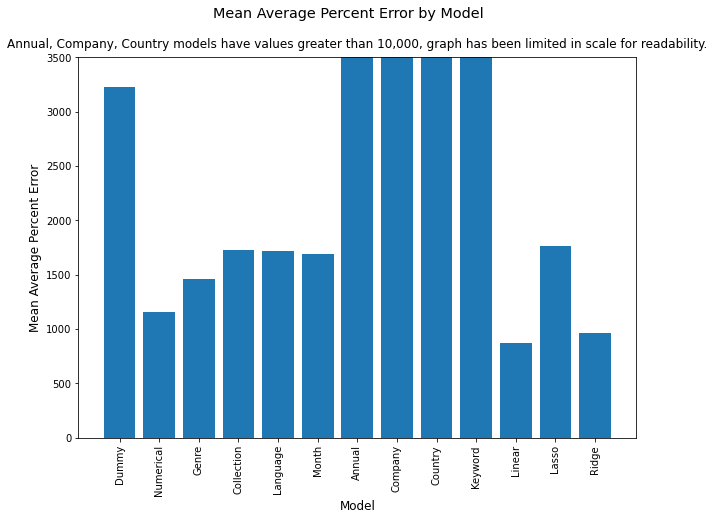

In [53]:
# Plot of the Mean Absolute Percentage Error scores
plt.figure(figsize=(10,7))
plt.bar(models, scores.MAPE)
plt.ylim(0, 3500)
plt.xticks(rotation=90)
plt.xlabel('Model', size='large')
plt.ylabel('Mean Average Percent Error', size='large')
plt.suptitle('Mean Average Percent Error by Model', size='x-large')
plt.title('Annual, Company, Country models have values greater than 10,000, ' 
          'graph has been limited in scale for readability.', pad=10);

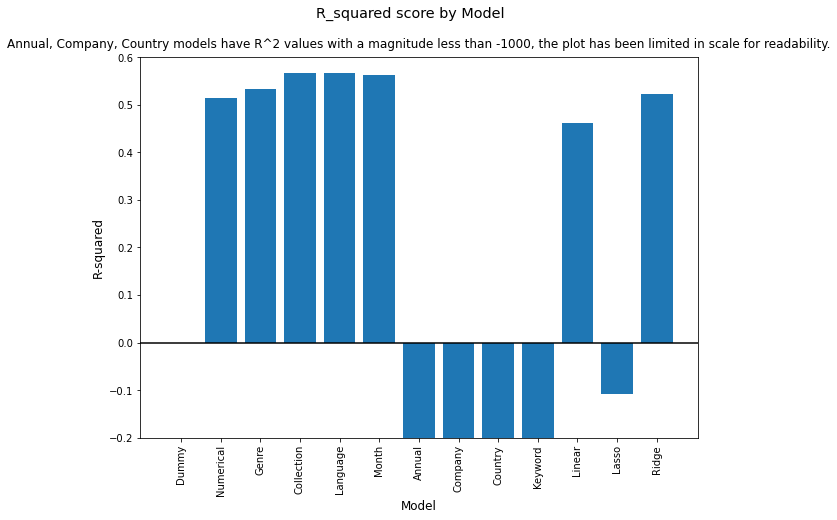

In [54]:
plt.figure(figsize=(10,7))
plt.bar(models, scores.R2)
plt.ylim(-0.2,0.6)
plt.xticks(rotation=90)
plt.xlabel('Model', size='large')
plt.ylabel('R-squared', size='large')
plt.suptitle('R_squared score by Model', size='x-large')
plt.title('Annual, Company, Country models have R^2 values with a magnitude less than -1000, '
         'the plot has been limited in scale for readability.', pad=10)
plt.axhline(0, c='black');

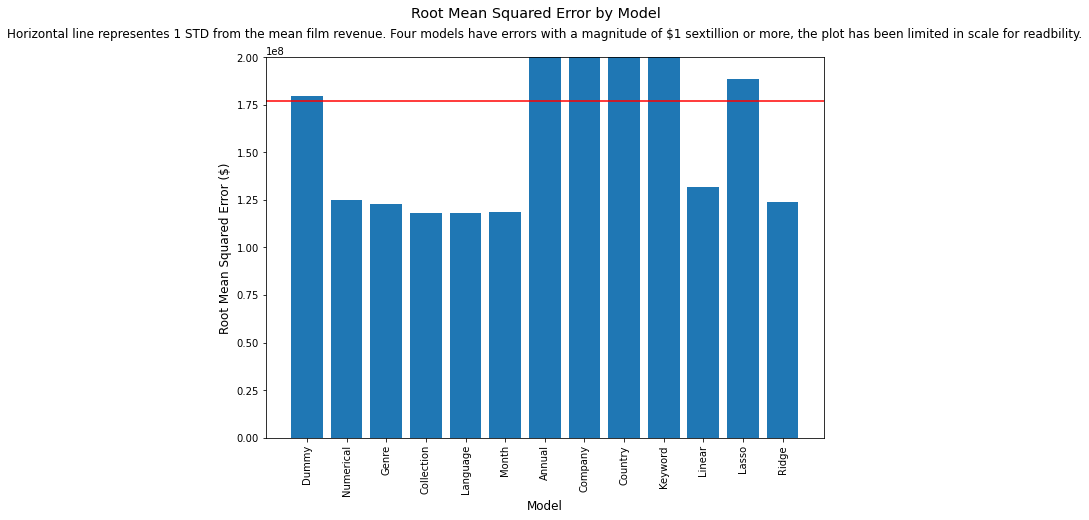

In [55]:
plt.figure(figsize=(10,7))
plt.bar(models, scores.RMSE)
plt.ylim(0, 200000000)
plt.xticks(rotation=90)
plt.xlabel('Model', size='large')
plt.ylabel('Root Mean Squared Error ($)', size='large')
plt.suptitle('Root Mean Squared Error by Model', size='x-large')
plt.title('Horizontal line representes 1 STD from the mean film revenue. Four models have errors with a magnitude of $1 sextillion or more, '
         'the plot has been limited in scale for readbility.', pad=20)
plt.axhline(176693296, c='red');

# Conclusions:

Moving forward it seems that the best performing model is a linear model that incorporates the entire data set.  It seems that the massive errors I was getting while using a macro elimination approach to check for overfitting were a result of eliminating one of the four categories that produce significant errors in the model **unless** all four categories are present, in which case the model provides the best metrics possible. 

This indicates that there is some interesting interaction among these categories which allow them together to provide more predictive power than they do seperately.

Of the other models I tested, using only the numerical data from the film's features provided the next best results, and a ridge regression model shows promise.  

This will inform my strategy moving forwards for building a model that will accurately predict the revenue of a film based on it's features. 

In [56]:
# Combine the scaled dataframe with the target variable, and save as a processed .csv file